# Project Overview

This notebook brings together anomaly detection, automated hyperparameter tuning and interpretability into a cohesive workflow. It is divided into three parts:

---

## Anomaly Detection with anomalib, MVTec AD & Optuna

I use MVTec Anomaly Detection along with the anomalib library to train defect detection models. I leverage Optuna to automatically find optimal hyperparameters for maximum anomaly detection accuracy.

---

## AutoML Framework Comparison: Optuna vs. iXAutoML vs. XAutoML

I compare three different frameworks—Optuna, iXAutoML, and XAutoML—to analyze their proposed approaches to automated model training. This is key to understanding the direction in which such frameworks are evolving.

---

## Hyperparameter Importance Analysis

### This section focuses on evaluating hyperparameter importance

First, I use **Optuna** to train multiple models with different parameter values. Then, I leverage three tools to assess feature importance:

- **Optuna-Dashboard** for interactive parameter importance analysis and results evaluation
- **Regression Trees** that take previously optimized hyperparameters (from Optuna) as input features
- **SHAP** to determine hyperparameter significance

Together, these three components provide clear insights and multiple approaches for evaluating hyperparameter importance.

---

## Detailed Description of MVTec Anomaly Detection

The MVTec Anomaly Detection dataset contains images across **15 object categories** (e.g., `bottle`, `cable`, `hazelnut`, `pill`, `carpet`, etc.). Each category directory includes three subfolders:

- `train/good/`: defect-free images for training.
- `test/good/`: defect-free images for evaluation of false positives.
- `test/[defect_type]/`: images exhibiting various defect types (e.g., cracks, scratches, contaminations)
- `ground_truth/[defect_type]/`: pixel-wise masks (0 = background, 255 = defect) corresponding to each defective test image.

---
## Anomalib Usage Examples

### Introduction to anomalib

Anomalib is a PyTorch-based library designed for **anomaly detection** tasks. It offers:

- **Modular pipelines:** Easily configure data loading, transformations, model architecture, and inference workflows.
- **Pretrained backbones:** Support for common CNN backbones (e.g., ResNet, EfficientNet) to extract rich features.
- **Detection and segmentation heads:** Built-in heads for both image-level anomaly detection and pixel-level anomaly localization.
- **Training utilities:** Simplified training loops, metrics logging, and checkpointing.
- **Inference and visualization:** Tools for generating anomaly maps, ROC curves, and overlay visualizations of defects.
- **Integration with optimization frameworks:** Seamless integration with libraries like Optuna for hyperparameter tuning.

---

### Example 1: Basic anomaly detection with Patchcore


In [ ]:
from anomalib.models import Patchcore
from anomalib.data import MVTecAD
from anomalib.engine import Engine
import warnings
import logging

logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")
dataset_path = r"C:\Users\pawel\Explainable-hyperparameter-optimization-in-anomaly-detection\datasets\MVTecAD"

train_batch_size = 2
coreset_sampling_ratio = 0.001
limit_train_batches = 2

datamodule = MVTecAD(
    root=dataset_path,
    category="cable",
    train_batch_size=train_batch_size,
    num_workers=4
)
model = Patchcore(
    backbone="resnet18",
    coreset_sampling_ratio=0.01,
    num_neighbors=50
)

engine = Engine(
    max_epochs=1,
    accelerator="cpu",
    limit_train_batches=limit_train_batches,
    callbacks=[]
)
engine.fit(datamodule=datamodule, model=model)

## Patchcore Simplified

### Model Core
- **Memory Bank System**:
  Stores normal image patterns from a pretrained network
  Compares new images against these patterns to spot defects
- **Key Parameter**:
  `coreset_sampling_ratio` - Controls memory bank size (lower = smaller/faster)

### Training Engine
- PyTorch Lightning-based processor
- Handles all training automatically
- Hardware control via `accelerator` (CPU/GPU)

### Critical Size Parameters
| Parameter | Effect on Coreset |
|-----------|-------------------|
| `coreset_sampling_ratio` | Directly sets memory bank size (0.01 = 1% of features stored) |
| `train_batch_size` | Affects feature extraction speed |
| `limit_train_batches` | Reduces processed images → smaller temporary memory use |

---
## Example 2: anomalib + Optuna

Optuna is a modern, open-source hyperparameter optimization framework designed for automatic and efficient tuning. It uses a define-by-run API, allowing you to dynamically construct search spaces with Python code. Key features include:

`Samplers`: Algorithms like Tree-structured Parzen Estimator (TPE) to sample promising hyperparameter combinations.

`Pruners`: Early stopping of unpromising trials to save computation.

`Flexible storage`: Built‑in support for SQLite or RDB backends to resume studies.

In the code below, Optuna searches over three hyperparameters of the Patchcore model:

`backbone`: choice between two pretrained architectures (resnet18, wide_resnet50_2).

`coreset_sampling_ratio`: float from 0.01 to 0.5 controlling memory bank size.

`num_neighbors`: integer from 1 to 100 for k-NN in anomaly scoring.

In [6]:
import optuna


def objective(trial):
    params = {
        "backbone": trial.suggest_categorical("backbone", ["resnet18", "wide_resnet50_2"]),
        "coreset_sampling_ratio": trial.suggest_float("coreset_sampling_ratio", 0.01, 0.5),
        "num_neighbors": trial.suggest_int("num_neighbors", 1, 100),
    }

    model = Patchcore(**params)
    engine = Engine(
        max_epochs=1,
        accelerator="cpu",
        limit_train_batches=limit_train_batches,
        callbacks=[]
    )

    datamodule = MVTecAD(
        root=dataset_path,
        category="cable",
        train_batch_size=train_batch_size,
        num_workers=4
    )

    engine.fit(datamodule=datamodule, model=model)
    metrics = engine.test(datamodule=datamodule, model=model)
    return metrics[0]["image_AUROC"]


# OPTUNA CONFIG
study = optuna.create_study(
    direction="maximize",
    study_name="anomalib_patchcore_tuning",
    storage="sqlite:///anomalib.db",
    load_if_exists=True,
)
study.optimize(objective, n_trials=10)


[I 2025-06-11 17:09:59,883] Using an existing study with name 'anomalib_patchcore_tuning3' instead of creating a new one.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type           | Params | Mode 
----------------------------------------------------------
0 | pre_processor  | PreProcessor   | 0      | train
1 | post_processor | PostProcessor  | 0      | train
2 | evaluator      | Evaluator      | 0      | train
3 | model          | PatchcoreModel | 24.9 M | train
----------------------------------------------------------
24.9 M    Trainable params
0         Non-trainable params
24.9 M    Total params
99.450    Total estimated model params size (MB)
19        Modules in train mode
174       Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]



Selecting Coreset Indices.:   0%|          | 0/129 [00:00<?, ?it/s]

Selecting Coreset Indices.: 100%|██████████| 129/129 [00:00<00:00, 952.55it/s]
`Trainer.fit` stopped: `max_epochs=1` reached.
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: Evaluator, ImageVisualizer, PostProcessor, PreProcessor


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        image_AUROC        │    0.9062968492507935     │
│       image_F1Score       │    0.8527919054031372     │
│        pixel_AUROC        │    0.9480305910110474     │
│       pixel_F1Score       │    0.5940976738929749     │
└───────────────────────────┴───────────────────────────┘

[I 2025-06-11 17:11:37,358] Trial 26 finished with value: 0.9062968492507935 and parameters: {'backbone': 'wide_resnet50_2', 'coreset_sampling_ratio': 0.04135107831377596, 'num_neighbors': 18}. Best is trial 6 with value: 0.9488381147384644.


# AutoML Framework Comparison

## Core Features

| Feature               | Optuna                          | Auto-sklearn (iXAutoML)         | XAutoML                         |
|-----------------------|---------------------------------|---------------------------------|---------------------------------|
| **Type**              | Hyperparameter Optimization     | End-to-End AutoML               | Low-Code AutoML                 |
| **Interface**         | Python API                      | Python/YAML config              | Web GUI                         |
| **Best For**          | Custom model tuning             | Automated ML pipelines          | Rapid prototyping               |
| **Learning Curve**    | Moderate                        | Steep                           | Gentle                          |

## Technical Comparison

| Aspect                | Optuna                | Auto-sklearn                  | XAutoML                         |
|-----------------------|-----------------------|-------------------------------|---------------------------------|
| **Search Algorithms** | TPE         | Bayesian optimization         | Predefined presets              |
| **Parallelization**   | Dask, Ray            |  (Multi-core)                | ❌                              |
| **Visualization**     | Basic (Plotly)        | Minimal                       | Interactive dashboards          |
| **DL Support**        | PyTorch/TF)          | ❌                            | ❌                              |
| **Data Preprocessing**| Manual             |  Automatic                   | Semi-automatic                  |

## When to Use Each

### Optuna
- Tuning PatchCore in Anomalib
- Custom neural architectures
- Research experiments

### Auto-sklearn
- Production ML pipelines
- Automated feature engineering
- When you need robust baselines

### XAutoML
- Quick POCs
- Non-technical users
- Educational purposes
---


# Ionosphere Dataset

## Basic Info
- **What**: Radar signal data
- **Goal**: Detect structures in the ionosphere ("good" or "bad" radar returns)
- **Type**: Binary classification (good/bad)

## Technical Details
- **Samples**: 351 instances
- **Features**: 34 numerical attributes
- **Target**: 1 binary class label ("g"=good, "b"=bad)

## Features
- Each row represents one radar return
- First 32 features are pulse measurements
- Last 2 features are special:
  - Feature 33-34: Additional measurements
  - Feature 35: Binary class label



---


# Isolation Forest (iForest)

## What it does
- Finds anomalies by **isolating** them instead of modeling normal data
- Works like a "spot the odd one out" game

## How it works
1. Randomly picks features
2. Randomly splits data values
3. Repeats to build many "isolation trees"
4. Anomalies get isolated faster (need fewer splits)

## Key features
- Fast on big datasets
- Doesn't need normal data examples
- Handles weird data shapes well

## Main parameters
- `n_estimators`: Number of trees (more=more accurate)
- `contamination`: Expected % of anomalies

In [26]:
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna.visualization as vis
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data"
columns = [f"f{i}" for i in range(34)] + ["label"]
df = pd.read_csv(url, header=None, names=columns)

X = df.iloc[:, :-1].values
y_raw = df["label"].values
y = (y_raw == 'b').astype(int)  # 'b' = anomalie, 'g' = normalne

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_samples = trial.suggest_float("max_samples", 0.2, 1.0)
    contamination = trial.suggest_float("contamination", 0.01, 0.2)
    max_features = trial.suggest_float("max_features", 0.3, 1.0)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    model = IsolationForest(
        n_estimators=n_estimators,
        max_samples=max_samples,
        contamination=contamination,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train)
    y_pred = model.predict(X_val)
    y_pred = (y_pred == -1).astype(int)

    return f1_score(y_val, y_pred)


study = optuna.create_study(
    direction="maximize",
    study_name="iforest_ionosphere",
    storage="sqlite:///iforest_ionosphere.db",
    load_if_exists=True
)
study.optimize(objective, n_trials=20)

print("Best score:", study.best_value)
print("Best params:", study.best_params)


[I 2025-06-12 23:40:00,639] Using an existing study with name 'iforest_ionosphere' instead of creating a new one.
[I 2025-06-12 23:40:02,268] Trial 241 finished with value: 0.5294117647058824 and parameters: {'n_estimators': 458, 'max_samples': 0.851452926026988, 'contamination': 0.18802108634074574, 'max_features': 0.4883571644369249, 'bootstrap': False}. Best is trial 146 with value: 0.6486486486486487.
[I 2025-06-12 23:40:03,467] Trial 242 finished with value: 0.5294117647058824 and parameters: {'n_estimators': 475, 'max_samples': 0.858357627994111, 'contamination': 0.1908795297427168, 'max_features': 0.534220452434547, 'bootstrap': False}. Best is trial 146 with value: 0.6486486486486487.
[I 2025-06-12 23:40:04,562] Trial 243 finished with value: 0.5294117647058824 and parameters: {'n_estimators': 488, 'max_samples': 0.8173407454232788, 'contamination': 0.19467202807612904, 'max_features': 0.5156635838783457, 'bootstrap': False}. Best is trial 146 with value: 0.6486486486486487.
[I

Best score: 0.6486486486486487
Best params: {'n_estimators': 478, 'max_samples': 0.8245551280650433, 'contamination': 0.19989798782425552, 'max_features': 0.5316837205965292, 'bootstrap': False}


ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [25]:
import optuna
from sklearn.tree import DecisionTreeRegressor

study = optuna.load_study(study_name="iforest_ionosphere", storage="sqlite:///iforest_ionosphere.db")

df = study.trials_dataframe()

df = df[df["state"] == "COMPLETE"]

df_model = df.drop(columns=["number", "state", "datetime_start", "datetime_complete", "duration"])
df_model = df_model.dropna(axis=1, how='all')
df_model = df_model.dropna()
print(df_model)

X = df_model.drop(columns=["value"])
y = df_model["value"]
tree = DecisionTreeRegressor(max_depth=4, random_state=42)
tree.fit(X, y)

        value  params_bootstrap  params_contamination  params_max_features  \
1    0.484848              True              0.107457             0.316018   
2    0.076923             False              0.022211             0.632236   
3    0.484848             False              0.098658             0.944344   
4    0.529412             False              0.180023             0.486613   
5    0.333333              True              0.050696             0.853152   
..        ...               ...                   ...                  ...   
236  0.571429             False              0.190851             0.526398   
237  0.529412             False              0.196764             0.471218   
238  0.529412             False              0.185407             0.439878   
239  0.571429             False              0.192537             0.518615   
240  0.571429             False              0.199582             0.408775   

     params_max_samples  params_n_estimators  
1              0

,criterion,'squared_error'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


# DecisionTreeRegressor


### Why a decision tree?

- **Built-in feature ranking**
  Decision trees naturally compute feature importance based on how often and how early each feature is used to split the data.

- **Interpretability**
  A shallow tree (depth 4) provides a clear, human-readable approximation of which hyperparameters most influence model performance.

---




In [3]:
importances = tree.feature_importances_
for feature, importance in zip(X.columns, importances):
    print(f"{feature}: {importance:.4f}")

params_bootstrap: 0.0000
params_contamination: 0.9617
params_max_features: 0.0159
params_max_samples: 0.0148
params_n_estimators: 0.0076


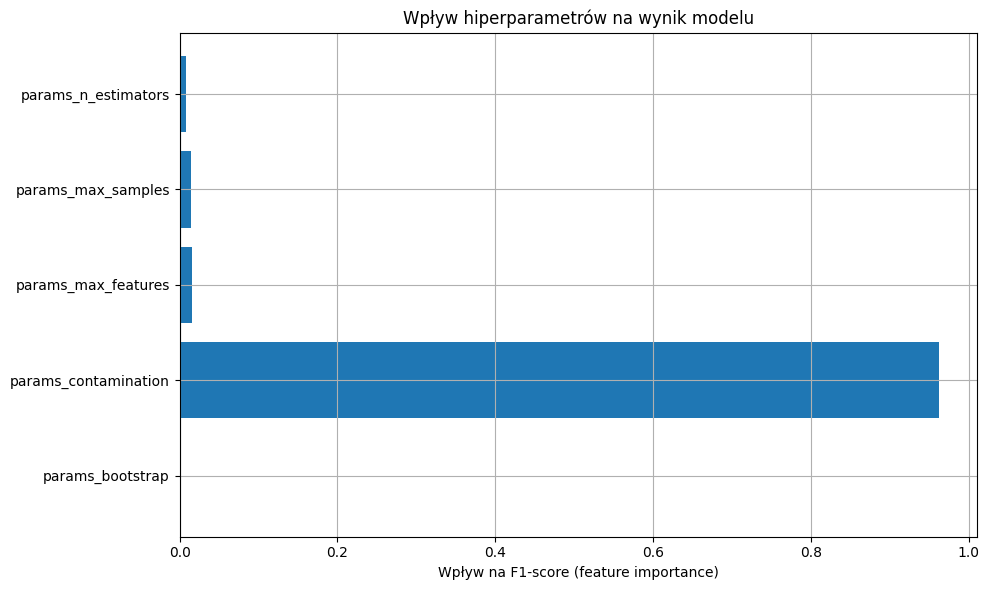

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(X.columns, importances)
plt.xlabel("Wpływ na F1-score (feature importance)")
plt.title("Wpływ hiperparametrów na wynik modelu")
plt.grid(True)
plt.tight_layout()
plt.show()





## SHAP (SHapley Additive exPlanations)

SHAP is a unified framework for interpreting predictions of any machine learning model by computing feature contributions based on cooperative game theory (Shapley values).

- **Core idea:**
  Each feature is treated as a “player” in a coalition. SHAP computes the average marginal contribution of each feature over all possible subsets, yielding fair “credit” for a given prediction.

- **Key properties:**
  1. **Local accuracy:** The sum of feature attributions equals the model’s output.
  2. **Missingness:** Features missing in the model get zero attribution.
  3. **Consistency:** If a model changes so a feature’s contribution increases, its SHAP value never decreases.

- **Common explainers:**
  - **`TreeExplainer`** for tree-based models (Decision Trees, Random Forests, Gradient Boosting).
  - **`KernelExplainer`** model-agnostic, but slower.

---

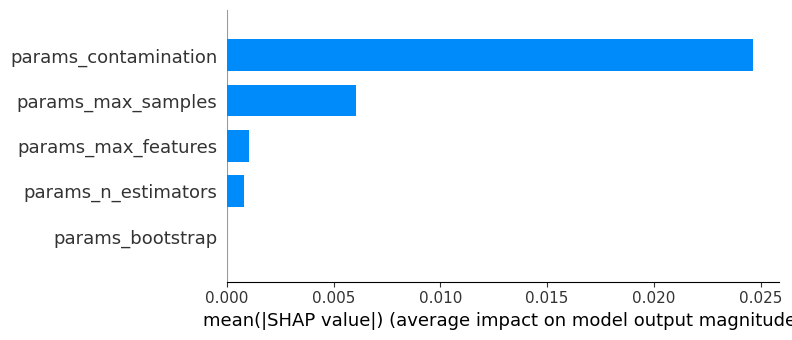

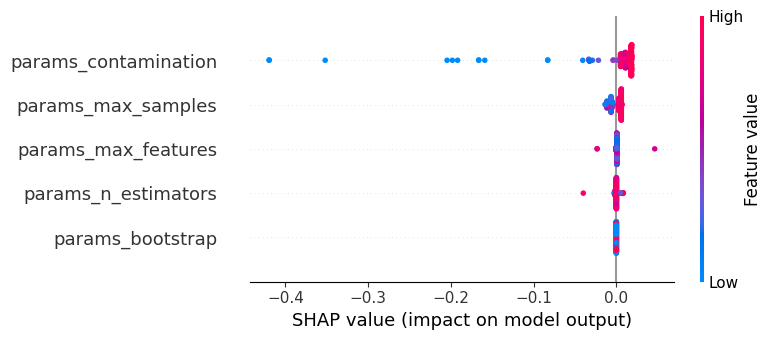

In [6]:
import shap
import matplotlib.pyplot as plt

X_params = df_model.drop(columns=["value"])
y_scores = df_model["value"]


explainer = shap.TreeExplainer(tree)
shap_values = explainer.shap_values(X_params)


shap.summary_plot(
    shap_values, X_params,
    plot_type="bar",
    show=True
)


shap.summary_plot(
    shap_values, X_params,
    plot_type="dot",
    show=True
)


# Anomaly Detection Models Overview

## One-Class SVM
- **Principle**: Finds decision boundary around normal data using kernel methods
- **Key Parameters**:
  - `kernel`: Kernel type (rbf, poly, sigmoid)
  - `nu`: Upper bound on anomaly fraction

## Elliptic Envelope
- **Principle**: Fits an ellipse assuming Gaussian distribution
- **Key Parameters**:
  - `support_fraction`: Fraction of points for estimation
  - `contamination`: Expected anomaly fraction

## Local Outlier Factor (LOF)
- **Principle**: Compares local density with neighbors' density
- **Key Parameters**:
  - `n_neighbors`: Number of neighbors to consider
  - `contamination`: Expected anomaly fraction


In [8]:
import optuna
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import f1_score
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

columns = [f"f{i}" for i in range(34)] + ["label"]
df = pd.read_csv(url, header=None, names=columns)

X = df.iloc[:, :-1].values
y_raw = df["label"].values
y = (y_raw == 'b').astype(int)  # 1 = anomalia (bad), 0 = normalna (good)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


def objective(trial):
    model_name = trial.suggest_categorical("model", ["IsolationForest", "OneClassSVM", "EllipticEnvelope", "LOF"])

    n_estimators = trial.suggest_int("n_estimators", 1, 500)
    max_samples = trial.suggest_float("max_samples", 0.1, 1.0)
    contamination = trial.suggest_float("contamination", 0.01, 0.5)
    max_features = trial.suggest_float("max_features", 0.1, 1.0)
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    kernel = trial.suggest_categorical("kernel", ["rbf", "sigmoid", "poly"])
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])
    nu = trial.suggest_float("nu", 0.01, 0.5)

    support_fraction = trial.suggest_float("support_fraction", 0.1, 1.0)

    n_neighbors = trial.suggest_int("n_neighbors", 10, 100)

    if model_name == "IsolationForest":
        model = IsolationForest(
            n_estimators=n_estimators,
            max_samples=max_samples,
            contamination=contamination,
            max_features=max_features,
            bootstrap=bootstrap,
            random_state=42, n_jobs=-1
        )
    elif model_name == "OneClassSVM":
        model = OneClassSVM(
            kernel=kernel,
            gamma=gamma,
            nu=nu
        )
    elif model_name == "EllipticEnvelope":
        model = EllipticEnvelope(
            contamination=contamination,
            support_fraction=support_fraction,
            random_state=42
        )
    elif model_name == "LOF":
        model = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            contamination=contamination,
            novelty=True,
            n_jobs=-1
        )
    else:
        raise ValueError("Nieznany model")

    model.fit(X_train)
    y_pred = model.predict(X_val)
    y_pred = (y_pred == -1).astype(int)

    return f1_score(y_val, y_pred)


study = optuna.create_study(
    direction="maximize",
    study_name="multi_model_outlier_study",
    storage="sqlite:///multi_model_outliers.db",
    load_if_exists=True
)
study.optimize(objective, n_trials=10, show_progress_bar=False)


[I 2025-06-11 22:43:29,886] Using an existing study with name 'multi_model_outlier_study' instead of creating a new one.
[I 2025-06-11 22:43:32,751] Trial 1 finished with value: 0.7346938775510204 and parameters: {'model': 'LOF', 'n_estimators': 241, 'max_samples': 0.6130961043088365, 'contamination': 0.3773842710885287, 'max_features': 0.23787150155275208, 'bootstrap': True, 'kernel': 'sigmoid', 'gamma': 'scale', 'nu': 0.25942741546120357, 'support_fraction': 0.8249700364272791, 'n_neighbors': 53}. Best is trial 1 with value: 0.7346938775510204.
[I 2025-06-11 22:43:33,104] Trial 2 finished with value: 0.5714285714285714 and parameters: {'model': 'IsolationForest', 'n_estimators': 86, 'max_samples': 0.9596680344493357, 'contamination': 0.2965719051916148, 'max_features': 0.16128821798452517, 'bootstrap': False, 'kernel': 'rbf', 'gamma': 'scale', 'nu': 0.2540661784585584, 'support_fraction': 0.452723141912418, 'n_neighbors': 63}. Best is trial 1 with value: 0.7346938775510204.
[I 2025-0

# Hyperparameter Analysis with Placeholder Replacement

## Why I Replace Unused Parameters

### The Problem I'm Solving:
When analyzing multiple models together, each model type uses different hyperparameters. This creates "gaps" in the DataFrame where certain parameters don't apply to certain models.

### My Solution Approach:
I systematically replace unused parameters with placeholder values (-1, -1.0, "NA", False) for three key reasons:

1. **Maintaining Numerical Consistency**
   - I use placeholders (-1, -1.0) to keep numerical columns machine-learning-ready
   - This prevents NaN values that could break tree-based models

2. **Enabling Clear Interpretation**
   - Placeholders create visual separation in feature importance plots
   - They help the tree learn to ignore irrelevant parameters for each model type

3. **Preparing for One-Hot Encoding**
   - I use categorical placeholders ("NA") for clean dummy variable conversion
   - Boolean placeholders (False) maintain consistent typing

In [2]:
import optuna
import pandas as pd
from sklearn.tree import DecisionTreeRegressor


study = optuna.load_study(
    study_name="multi_model_outlier_study",
    storage="sqlite:///multi_model_outliers.db"
)
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"]


df_model = df[[c for c in df.columns if c.startswith("params_")] + ["value"]]



if_mask = df_model["params_model"] != "IsolationForest"
df_model.loc[if_mask, [
    "params_n_estimators",
    "params_max_samples",
    "params_max_features",
    "params_bootstrap"
]] = [-1, -1.0, -1.0, False]


svm_mask = df_model["params_model"] != "OneClassSVM"
df_model.loc[svm_mask, [
    "params_kernel",
    "params_gamma",
    "params_nu"
]] = ["NA", "NA", -1.0]


ee_mask = df_model["params_model"] != "EllipticEnvelope"
df_model.loc[ee_mask, ["params_support_fraction"]] = -1.0


lof_mask = df_model["params_model"] != "LOF"
df_model.loc[lof_mask, ["params_n_neighbors"]] = -1


svm_only = df_model["params_model"] == "OneClassSVM"
df_model.loc[svm_only, ["params_contamination"]] = -1.0


categorical_cols = [c for c in df_model.columns if df_model[c].dtype == "object"]
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)


X = df_model.drop(columns=["value"])
y = df_model["value"]

tree = DecisionTreeRegressor(max_depth=4, random_state=42)
tree.fit(X, y)



,criterion,'squared_error'
,splitter,'best'
,max_depth,4
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


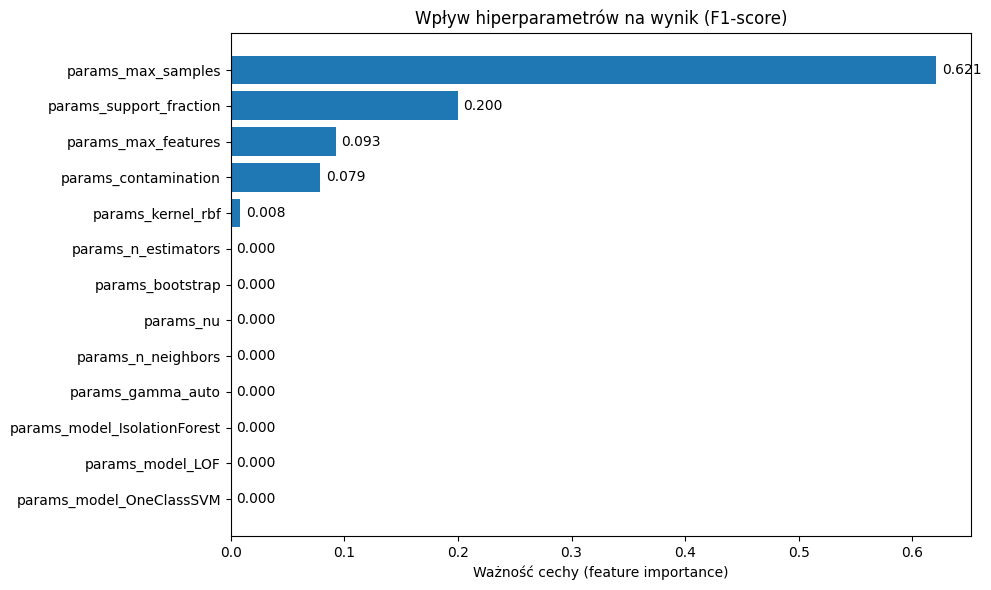

In [3]:
importances = tree.feature_importances_

importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance": importances
}).sort_values(by="importance", ascending=False)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df["feature"], importance_df["importance"])

for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height() / 2,
             f"{width:.3f}", va='center')

plt.xlabel("Ważność cechy (feature importance)")
plt.title("Wpływ hiperparametrów na wynik (F1-score)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()



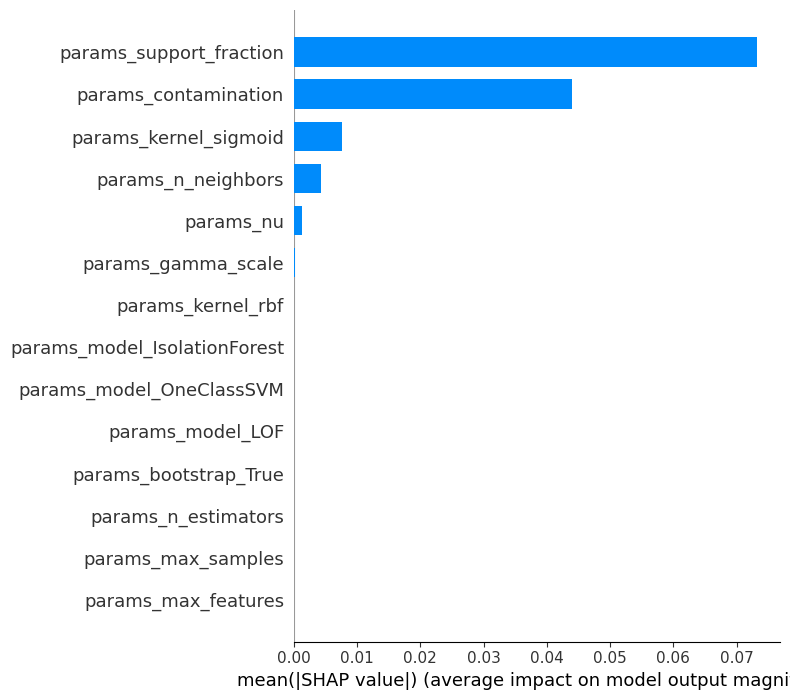

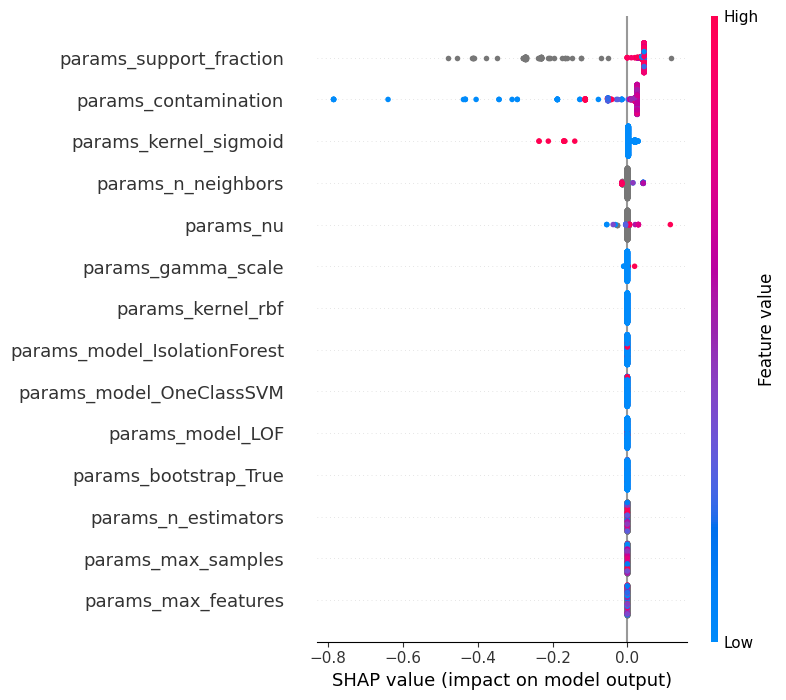

In [23]:
import shap

explainer = shap.TreeExplainer(tree)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X, plot_type="bar")
shap.summary_plot(shap_values, X, plot_type="dot", show=True)
